## 1

In [ ]:
import tensorflow as tf
import numpy as np
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class HyperParams:
    num_words = 768
    num_docs = 50
    sequence_len = 10
    batch_size = 16
    vocab_size = 252911
    embedded_size = 256
    num_units_bi_gru_1 = 128
    num_units_main_gru = 512
    num_units_main_gru_2 = 128
    num_units_post_dense_1 = 300
    num_units_post_dense_2 = 64
    num_output = 1
    validation_steps = 5
    auxiliary_x = 6

    lr = 1e-05
    fine_tune_epochs = 30
    fine_tune_batch_size = 16
    auto_tune = tf.data.experimental.AUTOTUNE
    opt = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.MeanSquaredError()
    epochs = 100
    metrics = ['mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          patience=10)
    r = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.8,
                                             patience=2,
                                             verbose=1,
                                             mode='auto',
                                             epsilon=0.0001,
                                             cooldown=5,
                                             min_lr=0.00001)


def tri_attention_rnn_model(plot_model=True,
                            summary_model=True):
    # word_input = tf.keras.Input(shape=HyperParams.num_words,
    #                             dtype='int64',
    #                             name='word_input')

    # Embedding layer
    # word_embedding = tf.keras.layers.Embedding(input_dim=HyperParams.vocab_size,
    #                                            output_dim=HyperParams.embedded_size)(word_input)
    # bi_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_bi_gru_1,
    #                                                              return_sequences=True))(word_embedding)
    # the first attention layer to capture the word-level attentions
    # attention_dense_1 = tf.keras.layers.Dense(HyperParams.num_units_bi_gru_1 * 2,
    #                                           activation='tanh')(bi_gru_1)
    # attention_softmax_1 = tf.keras.layers.Activation('softmax')(attention_dense_1)
    # attention_mul_1 = tf.keras.layers.multiply([attention_softmax_1, bi_gru_1])
    # vec_sum_1 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_1)
    # word_level_model = tf.keras.Model(inputs=word_input,
    #                                   outputs=vec_sum_1)

    doc_input = tf.keras.Input(shape=(HyperParams.num_docs, HyperParams.num_words),
                               dtype='float32',
                               name='doc_input')
    # post_bi_gru_1 = tf.keras.layers.TimeDistributed(word_level_model)(doc_input)

    # the second attention layer to capture the news-level attentions
    attention_dense_2 = tf.keras.layers.Dense(HyperParams.num_words, activation='tanh')(doc_input)
    attention_softmax_2 = tf.keras.layers.Activation('softmax')(attention_dense_2)
    attention_mul_2 = tf.keras.layers.multiply([attention_softmax_2, doc_input])
    vec_sum_2 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_2)
    doc_level_model = tf.keras.Model(inputs=doc_input, outputs=vec_sum_2)

    seq_input = tf.keras.Input(shape=(HyperParams.sequence_len, HyperParams.num_docs, HyperParams.num_words),
                               dtype='float32',
                               name='seq_input')

    # Incorporating the auxiliary variables
    auxiliary_input = tf.keras.Input(shape=(HyperParams.sequence_len, HyperParams.auxiliary_x),
                                     dtype='float32',
                                     name='auxiliary_input')
    pre_main_gru = tf.keras.layers.TimeDistributed(doc_level_model)(seq_input)
    pre_main_gru_concat = tf.keras.layers.concatenate([pre_main_gru, auxiliary_input], axis=-1)
    main_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_main_gru,
                                                                 return_sequences=True))(pre_main_gru_concat)
    main_gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_main_gru_2,
                                                                   return_sequences=True))(main_gru)

    # the third attention layer to capture the time-level attentions
    attention_dense_3 = tf.keras.layers.Dense(HyperParams.num_units_main_gru_2 * 2,
                                              activation='tanh')(main_gru_2)
    attention_softmax_3 = tf.keras.layers.Activation('softmax')(attention_dense_3)
    attention_mul_3 = tf.keras.layers.multiply([attention_softmax_3, main_gru_2])
    vec_sum_3 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_3)

    # Passing through multiple FC layers
    main_dense_1 = tf.keras.layers.Dense(HyperParams.num_units_post_dense_1,
                                         activation='tanh',
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,
                                                                                        l2=0.00001))(vec_sum_3)
    main_dropout_1 = tf.keras.layers.Dropout(0.1)(main_dense_1)
    main_dense_2 = tf.keras.layers.Dense(HyperParams.num_units_post_dense_2,
                                         activation='tanh',
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,
                                                                                        l2=0.00001))(main_dropout_1)
    main_dropout_2 = tf.keras.layers.Dropout(0.1)(main_dense_2)
    output = tf.keras.layers.Dense(HyperParams.num_output,
                                   activation=None)(main_dropout_2)

    model = tf.keras.Model(inputs=[seq_input, auxiliary_input], outputs=output)

    if plot_model:
        tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
    if summary_model:
        print(model.summary())
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 10, 50, 768) 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 10, 768)      590592      seq_input[0][0]                  
__________________________________________________________________________________________________
auxiliary_input (InputLayer)    [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 10, 774)      0           time_distributed[0][0]           
                                                                 auxiliary_input[0][0]      

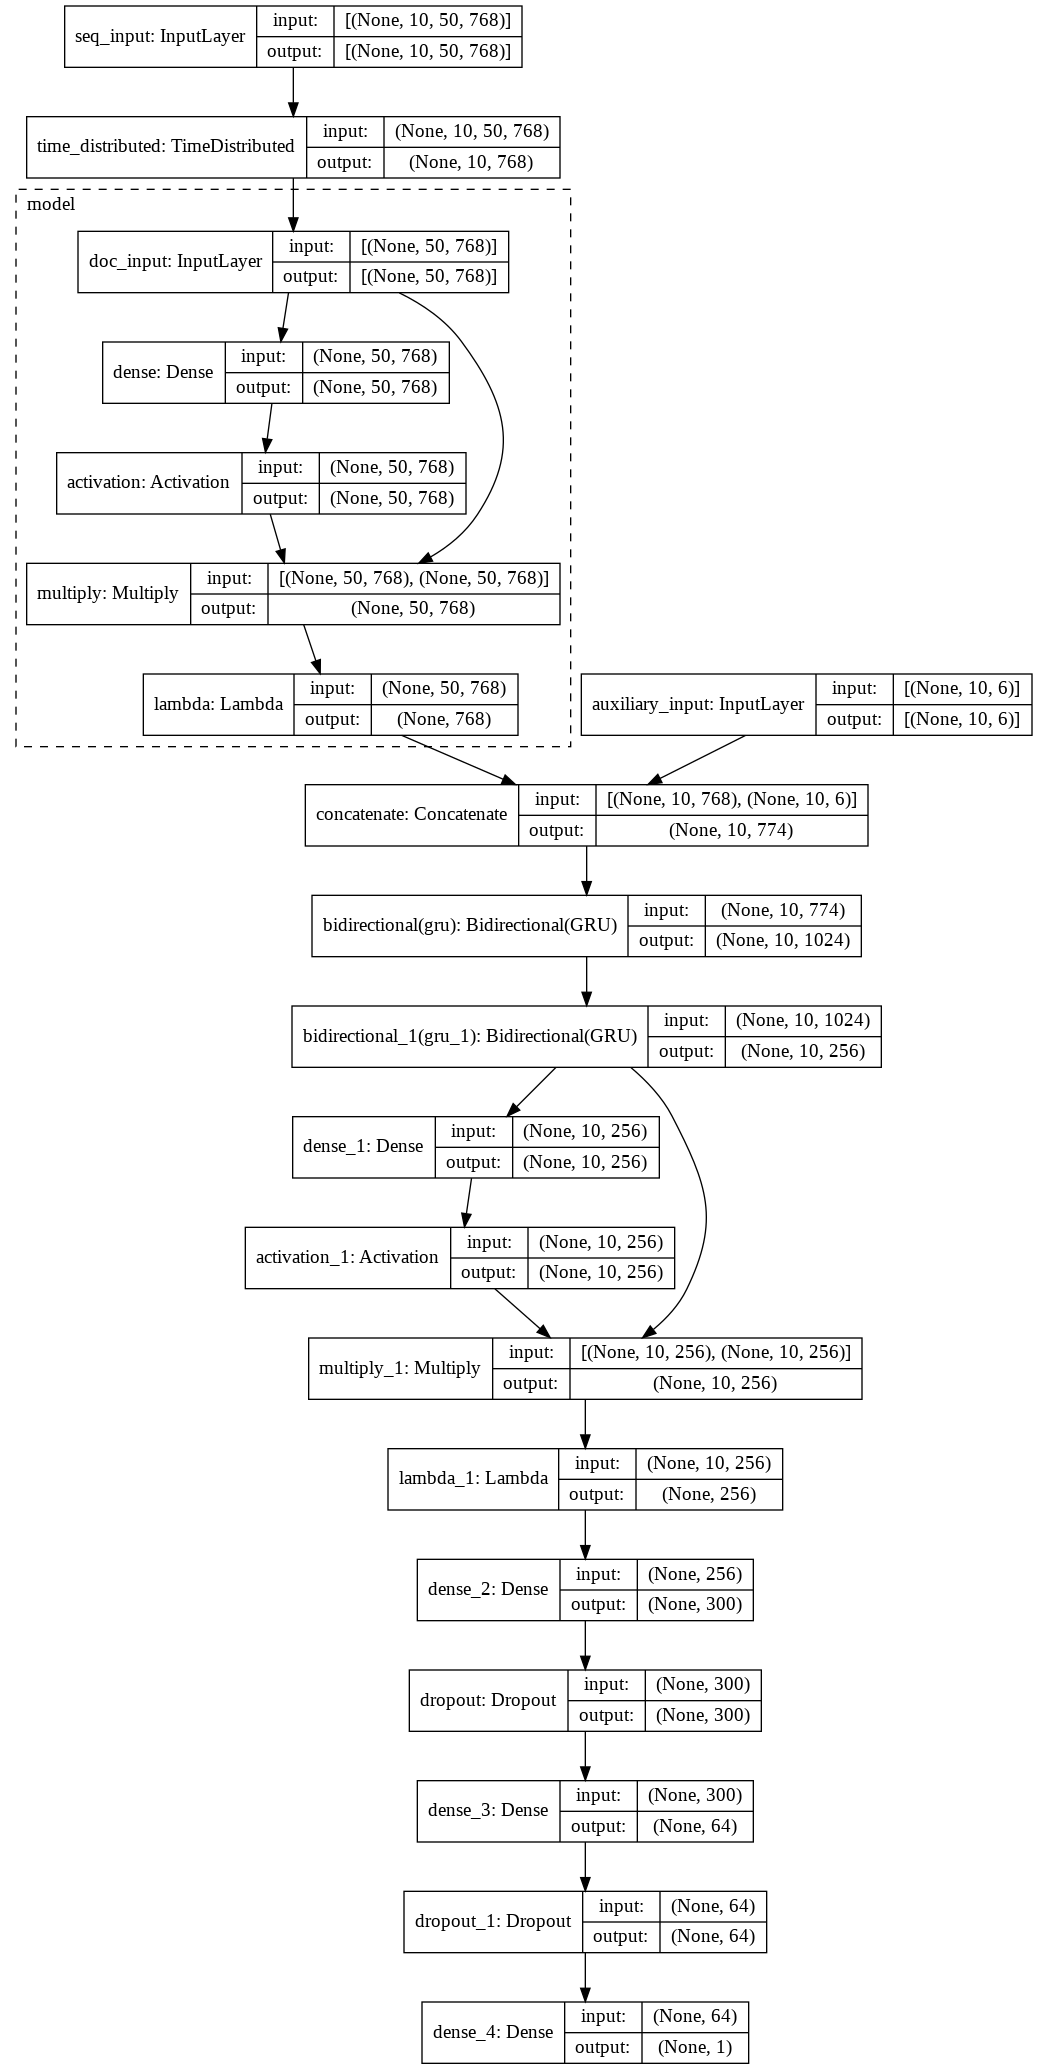

In [ ]:
m = tri_attention_rnn_model()
m.compile(optimizer=HyperParams.opt, loss=HyperParams.loss, metrics=HyperParams.metrics)
tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=True)

In [ ]:
def parse_data(x):
    description = {'x1': tf.io.FixedLenFeature([], tf.string, default_value=''),
                   'x2': tf.io.FixedLenFeature([], tf.string, default_value=''),
                   'y': tf.io.FixedLenFeature([], tf.float32, default_value=-1)}
    parsed_features = tf.io.parse_single_example(x, description)
    x1 = tf.io.decode_raw(parsed_features['x1'], 'float32')
    x1 = tf.reshape(x1, [HyperParams.sequence_len, HyperParams.num_docs, HyperParams.num_words])

    x2 = tf.io.decode_raw(parsed_features['x2'], 'float32')
    x2 = tf.reshape(x2, [HyperParams.sequence_len, HyperParams.auxiliary_x])

    y = parsed_features['y']

    return x1, x2, y


def load_data(file):
    df = tf.data.TFRecordDataset(file)
    df = df.map(parse_data)
    return df


def save_obj(obj, name):
    """
    :param obj:
    :param name:
    :return:
    """
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    """
    :param name:
    :return:
    """
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


def get_train_data(train_fn, batch_size: int = HyperParams.batch_size):
    df = load_data(train_fn)
    df = df.repeat().shuffle(64).batch(batch_size).prefetch(HyperParams.auto_tune)
    return df


def get_valid_data(valid_fn, batch_size: int = HyperParams.batch_size):
    df = load_data(valid_fn)
    df = df.repeat().shuffle(64).batch(batch_size).prefetch(HyperParams.auto_tune)
    return df

In [ ]:
df_train = get_train_data('/content/drive/MyDrive/2040 final/2040 final proj/novavax_train.tfrecords')
df_validation = get_valid_data('/content/drive/MyDrive/2040 final/2040 final proj/novavax_validation.tfrecords')

In [ ]:
def get_train_size(dir, n_max=10000):
    df = load_data(dir)
    df = df.batch(1).prefetch(HyperParams.auto_tune)
    s = 0
    for i, j, k in df.take(n_max):
        s += 1
    return s


n_train = get_train_size('/content/drive/MyDrive/2040 final/2040 final proj/pfizer_train.tfrecords')
print('IN ALL {} TRAINING SAMPLES.'.format(n_train))

IN ALL 5111 TRAINING SAMPLES.


In [ ]:
def train_generator(df):
    for i, j, k in df.as_numpy_iterator():
        yield ([i, j], k)


def validation_generator(df):
    for i, j, k in df.as_numpy_iterator():
        yield ([i, j], k)

In [ ]:
tg = train_generator(df_train)
vg = validation_generator(df_validation)

In [ ]:
history_m = m.fit(tg, validation_data=vg, batch_size=HyperParams.batch_size, epochs=HyperParams.epochs, steps_per_epoch=n_train//HyperParams.batch_size, validation_steps=HyperParams.validation_steps, callbacks=[HyperParams.es, HyperParams.r])
m.save('/content/drive/MyDrive/2040 final/2040 final proj/model_pfizer_bert.h5')
save_obj(history_m.history, '/content/drive/MyDrive/2040 final/2040 final proj/model_pfizer_bert_hist')

Epoch 1/100
319/319 [==============================] - 100s 245ms/step - loss: 0.3366 - mean_absolute_error: 0.4765 - mean_squared_error: 0.2806 - mean_squared_logarithmic_error: 0.1561 - val_loss: 0.0565 - val_mean_absolute_error: 0.0220 - val_mean_squared_error: 6.6613e-04 - val_mean_squared_logarithmic_error: 2.4134e-04
Epoch 2/100
319/319 [==============================] - 21s 67ms/step - loss: 0.0585 - mean_absolute_error: 0.0418 - mean_squared_error: 0.0028 - mean_squared_logarithmic_error: 0.0010 - val_loss: 0.0570 - val_mean_absolute_error: 0.0385 - val_mean_squared_error: 0.0017 - val_mean_squared_logarithmic_error: 6.2984e-04
Epoch 3/100
319/319 [==============================] - 27s 85ms/step - loss: 0.0580 - mean_absolute_error: 0.0425 - mean_squared_error: 0.0029 - mean_squared_logarithmic_error: 0.0011 - val_loss: 0.0554 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 6.8223e-04 - val_mean_squared_logarithmic_error: 2.4806e-04
Epoch 4/100
319/319 [============

In [ ]:
history_m_finetune = m.fit(tg, validation_data=vg, 
                             batch_size=HyperParams.fine_tune_batch_size,
                             epochs=HyperParams.fine_tune_epochs, 
                             steps_per_epoch=n_train//HyperParams.fine_tune_batch_size, 
                             validation_steps=HyperParams.validation_steps, 
                             callbacks=[HyperParams.es, HyperParams.r])
save_obj(history_m_finetune.history, '/content/drive/MyDrive/2040 final/2040 final proj/model_novavax_finetune1_hist')
m.save('/content/drive/MyDrive/2040 final/2040 final proj/model_novavax_finetune1.h5')

Epoch 1/30
324/324 [==============================] - 352s 1s/step - loss: 0.0529 - mean_absolute_error: 0.0899 - mean_squared_error: 0.0134 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0464 - val_mean_absolute_error: 0.0694 - val_mean_squared_error: 0.0071 - val_mean_squared_logarithmic_error: 0.0026
Epoch 2/30
324/324 [==============================] - 351s 1s/step - loss: 0.0525 - mean_absolute_error: 0.0897 - mean_squared_error: 0.0134 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0444 - val_mean_absolute_error: 0.0620 - val_mean_squared_error: 0.0055 - val_mean_squared_logarithmic_error: 0.0020
Epoch 3/30
324/324 [==============================] - 351s 1s/step - loss: 0.0519 - mean_absolute_error: 0.0893 - mean_squared_error: 0.0132 - mean_squared_logarithmic_error: 0.0048 - val_loss: 0.0411 - val_mean_absolute_error: 0.0469 - val_mean_squared_error: 0.0026 - val_mean_squared_logarithmic_error: 9.2013e-04
Epoch 4/30
324/324 [==============================] - 350

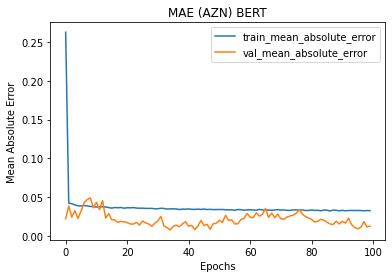

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_m.history['mean_absolute_error'], label='train_mean_absolute_error')
plt.plot(history_m.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('MAE (PFIZER) BERT')
plt.legend()
plt.show()

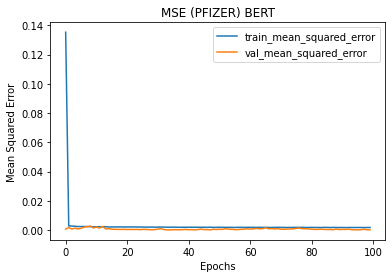

In [ ]:
plt.plot(history_m.history['mean_squared_error'], label='train_mean_squared_error')
plt.plot(history_m.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE (PFIZER) BERT')
plt.legend()
plt.show()

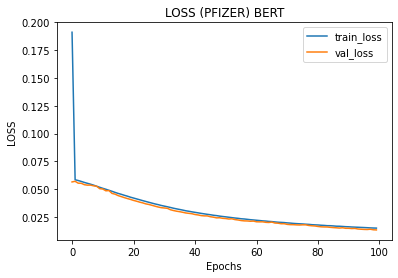

In [ ]:
plt.plot(history_m.history['loss'], label='train_loss')
plt.plot(history_m.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.title('LOSS (PFIZER) BERT')
plt.legend()
plt.show()

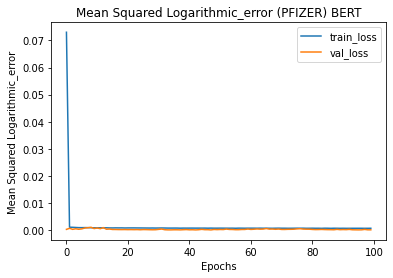

In [ ]:
plt.plot(history_m.history['mean_squared_logarithmic_error'], label='train_loss')
plt.plot(history_m.history['val_mean_squared_logarithmic_error'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Logarithmic_error')
plt.title('Mean Squared Logarithmic_error (PFIZER) BERT')
plt.legend()
plt.show()

## 2

In [ ]:
import tensorflow as tf
import numpy as np
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class HyperParams:
    num_words = 768
    num_docs = 50
    sequence_len = 10
    batch_size = 16
    vocab_size = 252911
    embedded_size = 256
    num_units_bi_gru_1 = 128
    num_units_main_gru = 512
    num_units_main_gru_2 = 128
    num_units_post_dense_1 = 300
    num_units_post_dense_2 = 64
    num_output = 1
    validation_steps = 5
    auxiliary_x = 6

    lr = 1e-05
    fine_tune_epochs = 30
    fine_tune_batch_size = 16
    auto_tune = tf.data.experimental.AUTOTUNE
    opt = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.MeanSquaredError()
    epochs = 100
    metrics = ['mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          patience=10)
    r = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.8,
                                             patience=2,
                                             verbose=1,
                                             mode='auto',
                                             epsilon=0.0001,
                                             cooldown=5,
                                             min_lr=0.00001)


def tri_attention_rnn_model(plot_model=True,
                            summary_model=True):
    # word_input = tf.keras.Input(shape=HyperParams.num_words,
    #                             dtype='int64',
    #                             name='word_input')

    # Embedding layer
    # word_embedding = tf.keras.layers.Embedding(input_dim=HyperParams.vocab_size,
    #                                            output_dim=HyperParams.embedded_size)(word_input)
    # bi_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_bi_gru_1,
    #                                                              return_sequences=True))(word_embedding)
    # the first attention layer to capture the word-level attentions
    # attention_dense_1 = tf.keras.layers.Dense(HyperParams.num_units_bi_gru_1 * 2,
    #                                           activation='tanh')(bi_gru_1)
    # attention_softmax_1 = tf.keras.layers.Activation('softmax')(attention_dense_1)
    # attention_mul_1 = tf.keras.layers.multiply([attention_softmax_1, bi_gru_1])
    # vec_sum_1 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_1)
    # word_level_model = tf.keras.Model(inputs=word_input,
    #                                   outputs=vec_sum_1)

    doc_input = tf.keras.Input(shape=(HyperParams.num_docs, HyperParams.num_words),
                               dtype='float32',
                               name='doc_input')
    # post_bi_gru_1 = tf.keras.layers.TimeDistributed(word_level_model)(doc_input)

    # the second attention layer to capture the news-level attentions
    attention_dense_2 = tf.keras.layers.Dense(HyperParams.num_words, activation='tanh')(doc_input)
    attention_softmax_2 = tf.keras.layers.Activation('softmax')(attention_dense_2)
    attention_mul_2 = tf.keras.layers.multiply([attention_softmax_2, doc_input])
    vec_sum_2 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_2)
    doc_level_model = tf.keras.Model(inputs=doc_input, outputs=vec_sum_2)

    seq_input = tf.keras.Input(shape=(HyperParams.sequence_len, HyperParams.num_docs, HyperParams.num_words),
                               dtype='float32',
                               name='seq_input')

    # Incorporating the auxiliary variables
    auxiliary_input = tf.keras.Input(shape=(HyperParams.sequence_len, HyperParams.auxiliary_x),
                                     dtype='float32',
                                     name='auxiliary_input')
    pre_main_gru = tf.keras.layers.TimeDistributed(doc_level_model)(seq_input)
    pre_main_gru_concat = tf.keras.layers.concatenate([pre_main_gru, auxiliary_input], axis=-1)
    main_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_main_gru,
                                                                 return_sequences=True))(pre_main_gru_concat)
    main_gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_main_gru_2,
                                                                   return_sequences=True))(main_gru)

    # the third attention layer to capture the time-level attentions
    attention_dense_3 = tf.keras.layers.Dense(HyperParams.num_units_main_gru_2 * 2,
                                              activation='tanh')(main_gru_2)
    attention_softmax_3 = tf.keras.layers.Activation('softmax')(attention_dense_3)
    attention_mul_3 = tf.keras.layers.multiply([attention_softmax_3, main_gru_2])
    vec_sum_3 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_3)

    # Passing through multiple FC layers
    main_dense_1 = tf.keras.layers.Dense(HyperParams.num_units_post_dense_1,
                                         activation='tanh',
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,
                                                                                        l2=0.00001))(vec_sum_3)
    main_dropout_1 = tf.keras.layers.Dropout(0.1)(main_dense_1)
    main_dense_2 = tf.keras.layers.Dense(HyperParams.num_units_post_dense_2,
                                         activation='tanh',
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,
                                                                                        l2=0.00001))(main_dropout_1)
    main_dropout_2 = tf.keras.layers.Dropout(0.1)(main_dense_2)
    output = tf.keras.layers.Dense(HyperParams.num_output,
                                   activation=None)(main_dropout_2)

    model = tf.keras.Model(inputs=[seq_input, auxiliary_input], outputs=output)

    if plot_model:
        tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
    if summary_model:
        print(model.summary())
    return model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 10, 50, 768) 0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 10, 768)      590592      seq_input[0][0]                  
__________________________________________________________________________________________________
auxiliary_input (InputLayer)    [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 10, 774)      0           time_distributed_2[0][0]         
                                                                 auxiliary_input[0][0]      

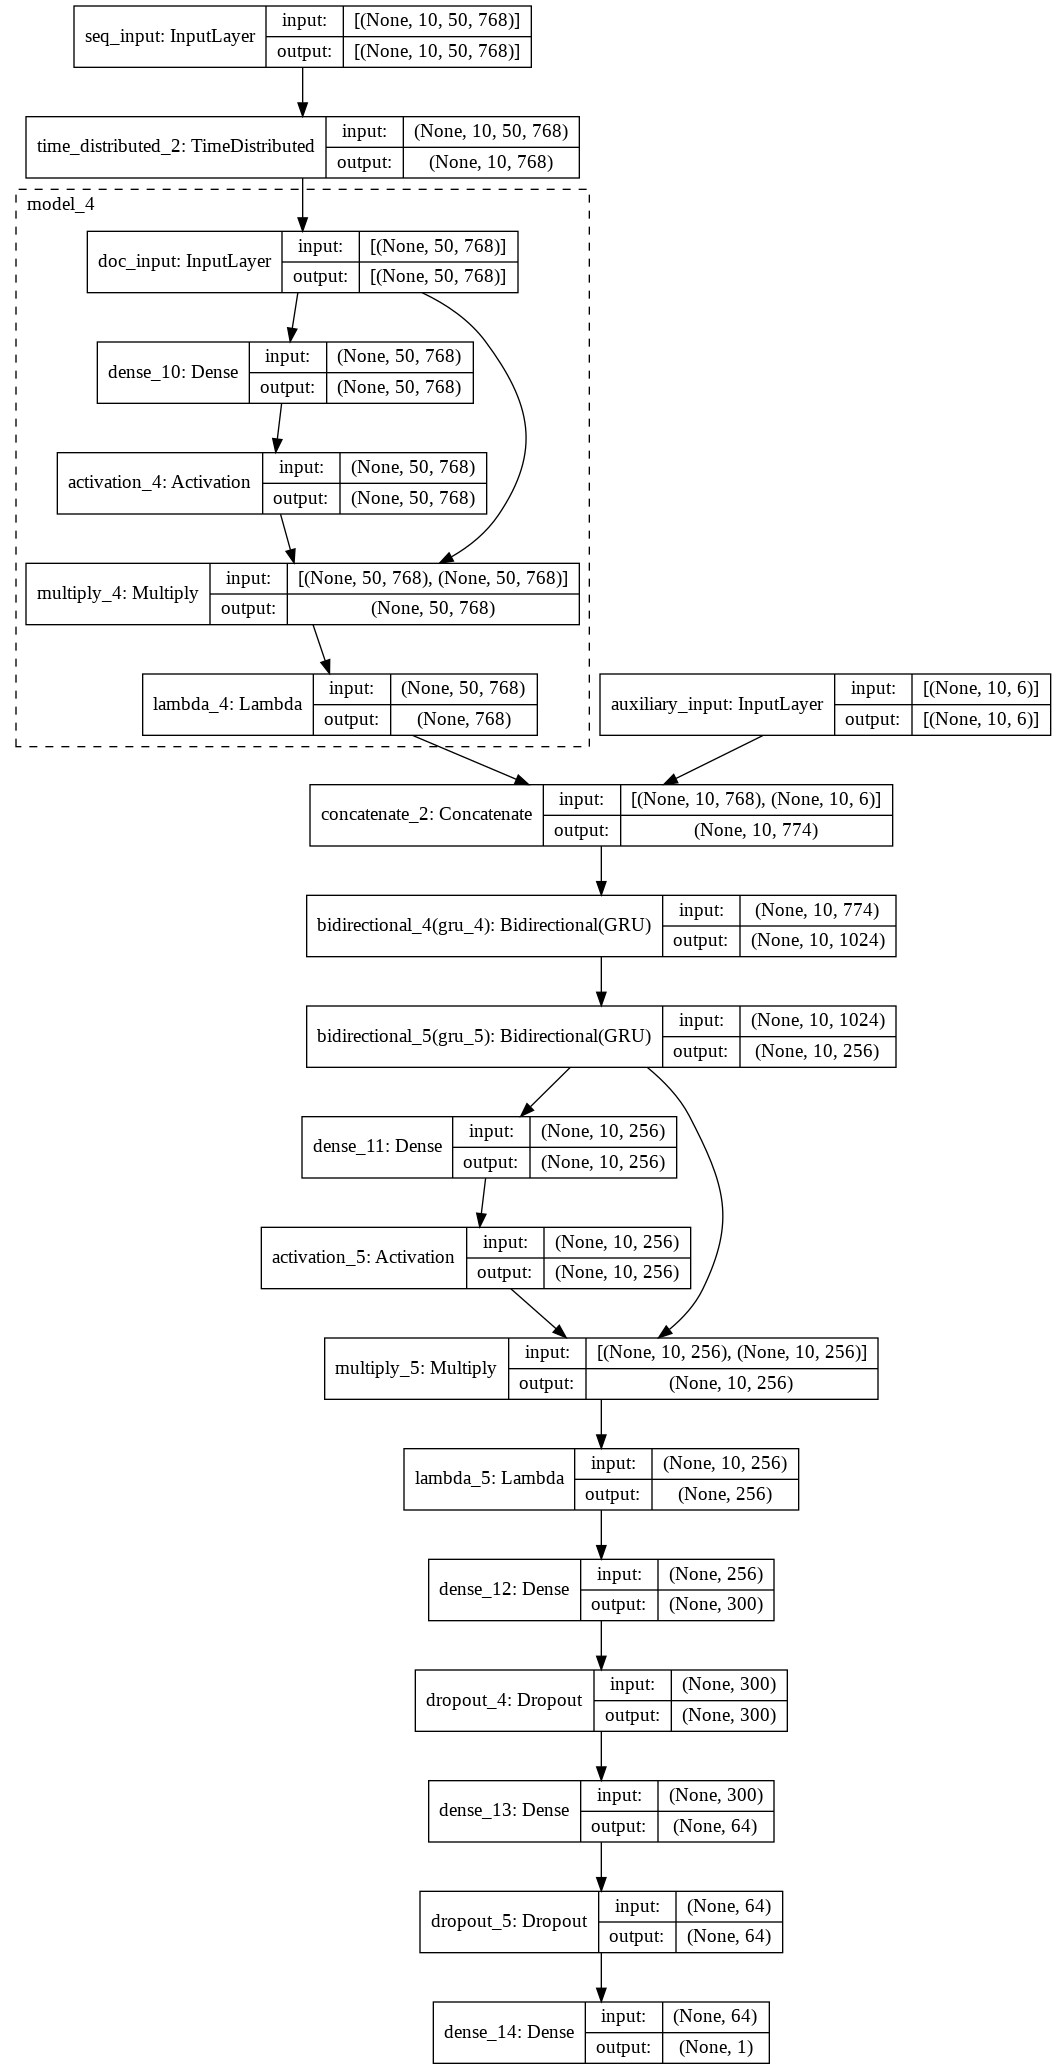

In [ ]:
m = tri_attention_rnn_model()
m.compile(optimizer=HyperParams.opt, loss=HyperParams.loss, metrics=HyperParams.metrics)
tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=True)

In [ ]:
def parse_data(x):
    description = {'x1': tf.io.FixedLenFeature([], tf.string, default_value=''),
                   'x2': tf.io.FixedLenFeature([], tf.string, default_value=''),
                   'y': tf.io.FixedLenFeature([], tf.float32, default_value=-1)}
    parsed_features = tf.io.parse_single_example(x, description)
    x1 = tf.io.decode_raw(parsed_features['x1'], 'float32')
    x1 = tf.reshape(x1, [HyperParams.sequence_len, HyperParams.num_docs, HyperParams.num_words])

    x2 = tf.io.decode_raw(parsed_features['x2'], 'float32')
    x2 = tf.reshape(x2, [HyperParams.sequence_len, HyperParams.auxiliary_x])

    y = parsed_features['y']

    return x1, x2, y


def load_data(file):
    df = tf.data.TFRecordDataset(file)
    df = df.map(parse_data)
    return df


def save_obj(obj, name):
    """
    :param obj:
    :param name:
    :return:
    """
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    """
    :param name:
    :return:
    """
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


def get_train_data(train_fn, batch_size: int = HyperParams.batch_size):
    df = load_data(train_fn)
    df = df.repeat().shuffle(64).batch(batch_size).prefetch(HyperParams.auto_tune)
    return df


def get_valid_data(valid_fn, batch_size: int = HyperParams.batch_size):
    df = load_data(valid_fn)
    df = df.repeat().shuffle(64).batch(batch_size).prefetch(HyperParams.auto_tune)
    return df

In [ ]:
df_train = get_train_data('/content/drive/MyDrive/2040 final/2040 final proj/novavax_train.tfrecords')
df_validation = get_valid_data('/content/drive/MyDrive/2040 final/2040 final proj/novavax_validation.tfrecords')

In [ ]:
def get_train_size(dir, n_max=10000):
    df = load_data(dir)
    df = df.batch(1).prefetch(HyperParams.auto_tune)
    s = 0
    for i, j, k in df.take(n_max):
        s += 1
    return s


n_train = get_train_size('/content/drive/MyDrive/2040 final/2040 final proj/novavax_train.tfrecords')
print('IN ALL {} TRAINING SAMPLES.'.format(n_train))

IN ALL 5182 TRAINING SAMPLES.


In [ ]:
def train_generator(df):
    for i, j, k in df.as_numpy_iterator():
        yield ([i, j], k)


def validation_generator(df):
    for i, j, k in df.as_numpy_iterator():
        yield ([i, j], k)

In [ ]:
tg = train_generator(df_train)
vg = validation_generator(df_validation)

In [ ]:
history_m = m.fit(tg, validation_data=vg, batch_size=HyperParams.batch_size, epochs=HyperParams.epochs, steps_per_epoch=n_train//HyperParams.batch_size, validation_steps=HyperParams.validation_steps, callbacks=[HyperParams.es, HyperParams.r])
m.save('/content/drive/MyDrive/2040 final/2040 final proj/model_novavax_bert.h5')
save_obj(history_m.history, '/content/drive/MyDrive/2040 final/2040 final proj/model_novavax_bert_hist')

Epoch 1/100
323/323 [==============================] - 28s 67ms/step - loss: 0.1754 - mean_absolute_error: 0.2555 - mean_squared_error: 0.1197 - mean_squared_logarithmic_error: 0.0621 - val_loss: 0.0627 - val_mean_absolute_error: 0.0673 - val_mean_squared_error: 0.0078 - val_mean_squared_logarithmic_error: 0.0029
Epoch 2/100
323/323 [==============================] - 20s 62ms/step - loss: 0.0702 - mean_absolute_error: 0.0945 - mean_squared_error: 0.0154 - mean_squared_logarithmic_error: 0.0057 - val_loss: 0.0605 - val_mean_absolute_error: 0.0674 - val_mean_squared_error: 0.0063 - val_mean_squared_logarithmic_error: 0.0022
Epoch 3/100
323/323 [==============================] - 24s 73ms/step - loss: 0.0690 - mean_absolute_error: 0.0923 - mean_squared_error: 0.0150 - mean_squared_logarithmic_error: 0.0056 - val_loss: 0.0568 - val_mean_absolute_error: 0.0485 - val_mean_squared_error: 0.0033 - val_mean_squared_logarithmic_error: 0.0012
Epoch 4/100
323/323 [==============================] - 

In [ ]:
history_m_finetune = m.fit(tg, validation_data=vg, 
                             batch_size=HyperParams.fine_tune_batch_size,
                             epochs=HyperParams.fine_tune_epochs, 
                             steps_per_epoch=n_train//HyperParams.fine_tune_batch_size, 
                             validation_steps=HyperParams.validation_steps, 
                             callbacks=[HyperParams.es, HyperParams.r])
save_obj(history_m_finetune.history, '/content/drive/MyDrive/2040 final/2040 final proj/model_novavax_finetune1_hist')
m.save('/content/drive/MyDrive/2040 final/2040 final proj/model_novavax_finetune1.h5')

Epoch 1/30
324/324 [==============================] - 352s 1s/step - loss: 0.0529 - mean_absolute_error: 0.0899 - mean_squared_error: 0.0134 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0464 - val_mean_absolute_error: 0.0694 - val_mean_squared_error: 0.0071 - val_mean_squared_logarithmic_error: 0.0026
Epoch 2/30
324/324 [==============================] - 351s 1s/step - loss: 0.0525 - mean_absolute_error: 0.0897 - mean_squared_error: 0.0134 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0444 - val_mean_absolute_error: 0.0620 - val_mean_squared_error: 0.0055 - val_mean_squared_logarithmic_error: 0.0020
Epoch 3/30
324/324 [==============================] - 351s 1s/step - loss: 0.0519 - mean_absolute_error: 0.0893 - mean_squared_error: 0.0132 - mean_squared_logarithmic_error: 0.0048 - val_loss: 0.0411 - val_mean_absolute_error: 0.0469 - val_mean_squared_error: 0.0026 - val_mean_squared_logarithmic_error: 9.2013e-04
Epoch 4/30
324/324 [==============================] - 350

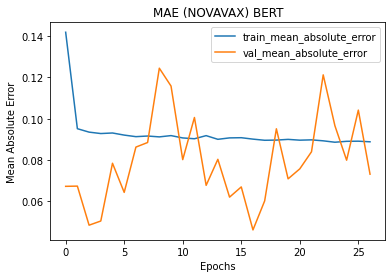

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_m.history['mean_absolute_error'], label='train_mean_absolute_error')
plt.plot(history_m.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('MAE (NOVAVAX) BERT')
plt.legend()
plt.show()

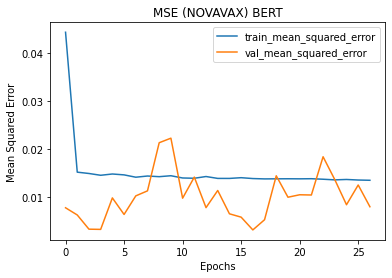

In [ ]:
plt.plot(history_m.history['mean_squared_error'], label='train_mean_squared_error')
plt.plot(history_m.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE (NOVAVAX) BERT')
plt.legend()
plt.show()

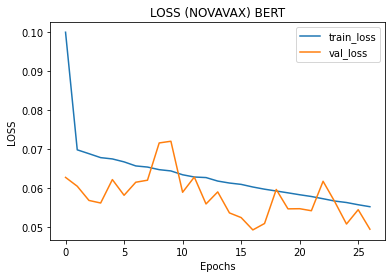

In [ ]:
plt.plot(history_m.history['loss'], label='train_loss')
plt.plot(history_m.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.title('LOSS (NOVAVAX) BERT')
plt.legend()
plt.show()

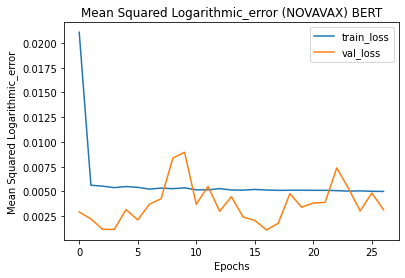

In [ ]:
plt.plot(history_m.history['mean_squared_logarithmic_error'], label='train_loss')
plt.plot(history_m.history['val_mean_squared_logarithmic_error'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Logarithmic_error')
plt.title('Mean Squared Logarithmic_error (NOVAVAX) BERT')
plt.legend()
plt.show()